Simple Kalman filter demo
=========================

In this demo, we'll build a Kalman filter using the ForneyLab toolbox. The goal is to filter noisy scalar observations.

Let `x_t_min` be the previous state of the system, `x_t` the current state, `u_t` the noisy system input and `y_t` the noisy observation of `x_t`:

\begin{align*}
    u_t &\sim \mathcal{N}(0, w)\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u_t\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the input and observations are corrupted by white Gaussian noise, with variance `w` and `v` respectively. 

The Kalman filter can be represented as a Forney-style factor graph:

```
                (u_t)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

The complete Kalman filter is obtained by chaining multiple of these sections.

Let's start by importing ForneyLab and defining the model for one section.

In [1]:
using ForneyLab

g = FactorGraph()

# Noise variances
w       = constant(0.01, id=:w) # variance of the input noise
v       = constant(200.0, id=:v) # variance of the observation noise

# State prior
prior_m = Variable(id=:prior_m)
prior_v = Variable(id=:prior_v)
x_t_min ~ GaussianMeanVariance(prior_m, prior_v)

# Transition and observation model
u_t     ~ GaussianMeanVariance(constant(1.0), w)
n_t     ~ GaussianMeanVariance(constant(0.0), v) # zero-mean gaussian observation noise
x_t     = x_t_min + u_t
y_t     = x_t + n_t

# Prior and data
placeholder(prior_m, :prior_m)
placeholder(prior_v, :prior_v)
placeholder(y_t,     :y_t);

Now that the factor graph is complete, we can generate an algorithm that computes the current state from the previous state prior and the currently observed data point.

In [2]:
schedule = sumProductSchedule(x_t) # Figure out a schedule
algo = messagePassingAlgorithm(schedule, x_t) # Compile the schedule to Julia code

println(algo)

function step!(marginals::Dict, data::Dict)

messages = Array{Message}(5)

messages[1] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=data[:prior_m]), Message(PointMass, m=data[:prior_v]), nothing)
messages[2] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=1.0), Message(PointMass, m=0.01), nothing)
messages[3] = ruleSPAdditionGGV(messages[1], messages[2], nothing)
messages[4] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=0.0), Message(PointMass, m=200.0), nothing)
messages[5] = ruleSPAdditionVGP(nothing, messages[4], Message(PointMass, m=data[:y_t]))

marginals[:variable_4] = messages[3].dist * messages[5].dist

end


We can visualize the factor graph for the model and the schedule

In [3]:
ForneyLab.draw(g, schedule=schedule)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 16662560840721292246 -->
 16662560840721292246 
 
 placeholder_prior_v 
 
<!-- 1711155585306581551 -->
 1711155585306581551 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 16662560840721292246--1711155585306581551 -->
 16662560840721292246--1711155585306581551 
 
 2 variance 
 1 out 
 
<!-- 4276140513420842866 -->
 4276140513420842866 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 18248691318833967910 -->
 18248691318833967910 
 
 clamp_1 
 
<!-- 4276140513420842866--18248691318833967910 -->
 4276140513420842866--18248691318833967910 
 
 1 out 
 1 mean 
 
<!-- 9393231034058449192 -->
 9393231034058449192 
 
 w 
 
<!-- 4276140513420842866--9393231034058449192 -->
 4276140513420842866--9393231034058449192 
 
 1 out 
 2 variance 
 
<!-- 7647209897063149406 -->
 7647209897063149406 
 
 placeholder_y_t 
 
<!-- 17488960970414871762 -->
 17488960970414871762 
 
 + 
 addition_2 
 
<!-- 7647209897063149406--17488960970414871762 -->
 7647209897063149406--17488960970414871762 
 
 3 out 
 1 out 
 
<!-- 6016044245034406177 -->
 6016044245034406177 
 
 placeholder_prior_m 
 
<!-- 6016044245034406177--1711155585306581551 -->
 6016044245034406177--1711155585306581551 
 
 1 mean 
 1 out 
 
<!-- 9758499154512383907 -->
 9758499154512383907 
 
 + 
 addition_1 
 
<!-- 9758499154512383907--1711155585306581551 -->
 9758499154512383907--1711155585306581551 
 
 3 out 
 (1) 
 1 in1 
 
<!-- 9758499154512383907--4276140513420842866 -->
 9758499154512383907--4276140513420842866 
 
 3 out 
 (2) 
 2 in2 
 
<!-- 6041632554080798478 -->
 6041632554080798478 
 
 v 
 
<!-- 4812825165820901796 -->
 4812825165820901796 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 4812825165820901796--6041632554080798478 -->
 4812825165820901796--6041632554080798478 
 
 1 out 
 2 variance 
 
<!-- 82759740440305278 -->
 82759740440305278 
 
 clamp_2 
 
<!-- 4812825165820901796--82759740440305278 -->
 4812825165820901796--82759740440305278 
 
 1 out 
 1 mean 
 
<!-- 17488960970414871762--9758499154512383907 -->
 17488960970414871762--9758499154512383907 
 
 3 out 
 (3) 
 1 in1 
 (5) 
 
<!-- 17488960970414871762--4812825165820901796 -->
 17488960970414871762--4812825165820901796 
 
 3 out 
 (4) 
 2 in2

Now we will generate some toy data

In [4]:
# Data
n_samples = 100
y_true = [t for t=1:n_samples] # Non-noisy values
y = y_true + sqrt(200.0)*randn(n_samples); # Noisy observations of y_true

All set. Now we apply the filter by recurively applying the forward algorithm to the data. 

In [5]:
# Define algorithm
eval(parse(algo))

prior_m = 0.0
prior_v = 1000.0
x_m = Float64[]
x_v = Float64[]
marginals = Dict()
for t = 1:n_samples
    data = Dict(:prior_m => prior_m, :prior_v => prior_v, :y_t => y[t])
    step!(marginals, data)
    ForneyLab.ensureParameters!(marginals[:variable_4], (:m, :v))
    post_m = marginals[:variable_4].params[:m]
    post_v = marginals[:variable_4].params[:v]
    push!(x_m, post_m)
    push!(x_v, post_v)
    prior_m = post_m
    prior_v = post_v
end

That was easy!
Let's plot the filter output (mean and standard deviation of `x_t`) together with the noisy observations to see if it worked.

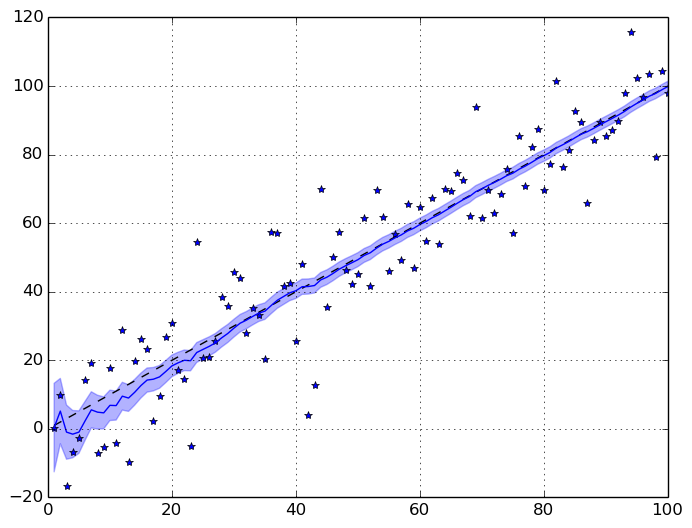

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [6]:
using PyPlot

plot(collect(1:n_samples), y, "b*")
plot(collect(1:n_samples), y_true, "k--")
plot(collect(1:n_samples), x_m, "b-")
fill_between(collect(1:n_samples), x_m-sqrt(x_v), x_m+sqrt(x_v), color="b", alpha=0.3);
grid(true)